# 4. 신경망 학습 

> 이번장에서 배운 내용
> * 신경망 학습은 손실 함수를 지표로, 손실 함수의 값이 작아지는 방향으로 가중치 매개변수를 갱신
> * 가중치 매개변수를 갱신할 때는 가중치 매개변수의 기울기를 이용, 기울어진 방향으로 가중치의 값을 갱신하는 작업 반복
> * 아주 작은 값을 주었을 때의 차분으로 미분하는 것을 수치 미분이라고 함
> * 수치 미분을 이용해 가중치 매개변수의 기울기를 구할 수 있음
> * 수치 미분을 이용한 계산에는 시간이 걸리지만, 구현은 간단
> * 다음 장에서 구현하는 오차역전파법은 기울기를 고속으로 구할 수 있음

* __학습__: 훈련 데이터로부터 가중치 매개변수의 최적값을 자동으로 획득하는 것
* __손실 함수__: 신경망이 학습할 수 있도록 해주는 지표
* 즉, 손실 함수의 결괏값을 가장 작게 만드는 가중치 매개변수를 찾는 것이 학습의 목표
* __경사법__: 손실 함수의 값을 가급적 작게 만드는 기법으로, 함수의 기울기를 활용

## 데이터 주도 학습

<br>

* 위와 같이 신경망은 이미지에 포함된 중요한 특징까지도 '기계'가 스스로 학습
* 그래서 딥러닝(신경망)을 end-to-end machine learning이라고도 함
* 신경망의 이점은 모든 문제를 같은 맥락에서 풀 수 있다는 점

## 손실함수

<br>

* 신경망은 손실 함수를 지표로 최적의 매개변수 값을 탐색
* 일반적으로 오차제곱합과 교차 엔트로피 오차를 사용

<br>

### 오차제곱합
* sum of squares for error, SSE

<br>

In [40]:
import numpy as np

def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [41]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t)) # 0.09750000000000003

In [42]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t)) # 0.5975

<br>

### 교차 엔트로피 오차
* cross entropy error, CEE
* 실질적으로 정답일 때의 추정(t_k가 1일 때의 y_k)의 자연로그를 계산하는 식
* 교차 엔트로피 오차는 정답일 때의 출력이 전체 값을 정하게 된다.

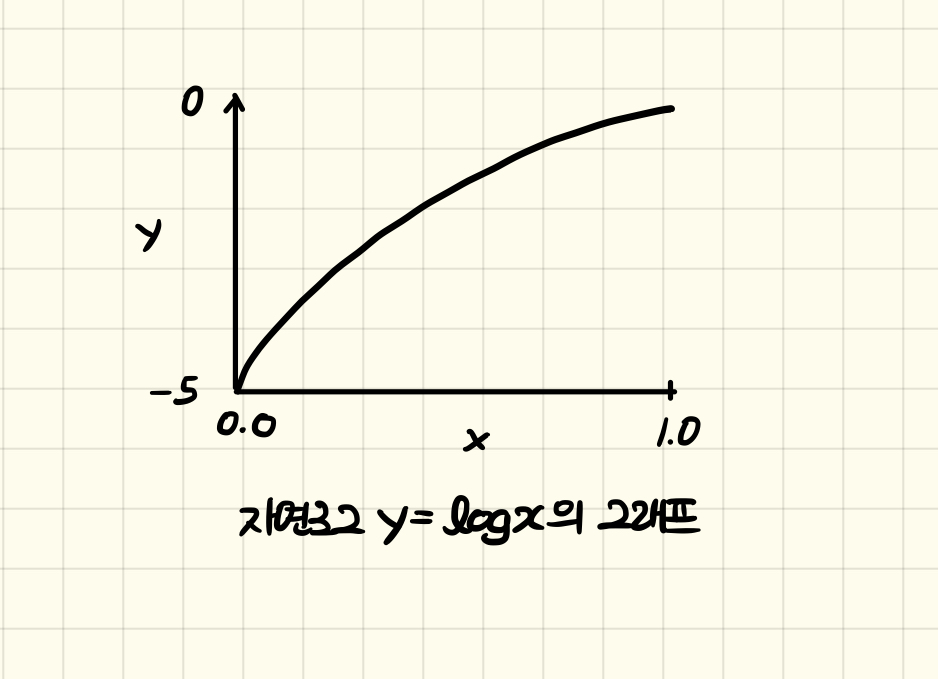

* 정답에 해당하는 출력이 커질수록 0에 다가가다가, 그 출력이 1일 때 0이 된다.
* 반대로 정답일 때의 출력이 작아질수록 오차는 커진다.

In [43]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))
# np.log() 함수에 0을 입력하면 마이너스 무한대가 되어 계산을 진행할 수 없으므로 아주 작은 값을 더해준다.

<br>

## 미니배치 학습

<br>

* 학습 시, 훈련 데이터에 대한 손실 함수의 값을 구하고, 그 값을 최대한 줄여주는 매개변수를 찾아낸다.
* 100개의 훈련 데이터가 있으면 100개의 손실 함수 값들의 합을 지표로 삼아야 한다.
* 마지막에 N으로 나누어 정규화하는데, '평균 손실 함수'를 구하는 것
* 이를 통해, 훈련 데이터 개수와 관계없이 언제든 통일된 지표를 얻을 수 있다.

<br>

* 그러나 많은 데이터들 대상으로 일일이 손실 함수를 계산하는 것은 현실적이지 않다.
* 이런 경우 데이터의 일부를 추려 전체의 '근사치'로 이용할 수 있다.
* 이를 미니배치(mini-batch)라고 한다.
* 예를 들어 6만 장의 훈련 데이터에서 100장을 무작위로 뽑아 학습하는 것

In [9]:
import numpy as np
from master.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

(60000, 784)
(60000, 10)


In [12]:
# (배치용) 교차 엔트로피 오차 구현
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = t.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [13]:
# 정답 레이블이 원핫인코딩이 아니라 숫자 레이블로 주어졌을 때
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = t.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

<br>

## 왜 손실 함수를 설정하는가?

<br>

* '정확도'라는 지표를 놔두고 '손실 함수의 값'이라는 우회적인 방법을 택하는 이유?
* '미분'의 역할
* 매개 변수의 미분(기울기)를 계산하고, 그 미분 값을 단서로 매개변수의 값을 갱신
* 가중치 매개변수의 손실 함수의 미분: '가중치 매개변수의 값을 아주 조금 변화시켰을 때, 손실 함수가 어떻게 변하나'
* 정확도를 지표로 삼을 수 없는 이유는 미분 값이 대부분의 장소에서 0이 되어 매개변수를 갱신할 수 없기 때문
* 정확도는 매개변수의 미소한 변화에는 거의 반응을 보이지 않고, 반응이 있어도 값이 불연속적으로 갑자기 변화함 

<br>

## 미분 

<br>

* 아주 작은 차분으로 미분하는 것: 수치 미분(numerical differentiation)
* 수식을 전개해 미분하는 것: 해석적 해
* 변수가 여럿인 함수에 대한 미분을 '편미분'이라 함
* 편미분은 변수가 하나인 미분과 마찬가지로 특정 장소의 기울기를 구함
* 단, 여러 변수 중 목표 변수 하나에 초점을 맞추고 다른 변수는 값을 고정함

<br>

## 기울기

* 모든 변수의 편미분을 벡터로 정리한 것을 기울기(gradient)라고 함
* 기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향

<br>

### 경사하강법

* 학습 단계에서 최적의 매개변수를 찾아내야함
* 최적이란 손실 함수가 최솟값이 될 때의 매개변수 값
* 기울기를 잘 이용해 함수의 최솟값(또는 가능한 한 작은 값)을 찾으려는 것이 경사하강법
* 함수가 극솟값, 최솟값, 또 안장점(saddle point)이 되는 장소에서 기울기가 0
* 그러므로, 경사법은 기울기가 0인 장소를 찾지만 그것이 반드시 최솟값이라고는 할 수 없음
* 그러나 그 방향으로 가야 함수의 값을 줄일 수 있음
* 최댓값을 찾을 경우 경사 상승법(gradient ascent method)
* 이 때, '학습률(learning rate)'라는 하이퍼 파라미터를 적절하게 정하는 것이 중요

## 학습 알고리즘 구현하기

< 전제 >
* 신경망에는 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 함
<br>

< 1단계 - 미니배치 >
* 훈련 데이터 중 일부를 무작위로 가져옴
* 이를 미니배치라고 하며, 미니배치의 손실함수 값을 줄이는 것이 목표
<br>

< 2단계 - 기울기 산출 >
* 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구함
* 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시
<br>

< 3단계 - 매개변수 갱신 >
* 가중치 매개변수를 기울기 방향으로 아주 조금 갱신
<br>

< 4단계 - 반복 >
* 1 ~ 3단계를 반복

<br>

* 이는 경사 하강법으로 매개변수를 갱신하는 방법   
* 데이터를 미니배치로 무작위로 선정하기 때문에 __확률적 경사 하강법(stochastic gradient descent, SGD)__ 라고 함

### 2층 신경망 클래스 구현

In [37]:
from master.common.functions import *
from master.common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        
        # 가중치 초기화
        self.params = {} # 가중치 매개변수 저장
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    # x: 입력 데이터, t: 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {} # params 변수에 대응하는 각 매개변수의 기울기가 저장
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

### 미니배치 학습 구현

In [39]:
import numpy as np
from master.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# Hyper parameter
iters_num = 10000 # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

### 시험 데이터로 평가하기

* 신경망 학습에서는 훈련 데이터 외의 데이터를 올바르게 인식하는지를 확인해야함
* 'over-fitting'을 일으키지 않는지 확인
* 학습 도중 정기적으로 훈련 데이터와 시험 데이터를 대상으로 정확도를 기록
* 여기서는 1 epoch별로 훈련 데이터와 시험 데이터에 대한 정확도를 기록
* epoch은 하나의 단위로, 1 epoch은 학습에서훈련 데이터를 모두 소진했을 때의 횟수에 해당
* 훈련 데이터 10,000개를 100개의 미니배치로 학습할 경우, 확률적 경사 하강법을 100회 반복하면 모든 훈련 데이터를 소진
* 이 경우, 100회가 1 epoch

In [ ]:
import numpy as np
from master.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# Hyper parameter
iters_num = 10000 # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1 epoch 당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('train acc, test acc | ' + str(train_acc) + ', ' + str(test_acc))